##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [87]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [88]:
orig_df = pd.read_csv('/Users/samyu1/Downloads/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [89]:
df = pd.read_csv('/Users/samyu1/Downloads/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [90]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [91]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [92]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.



## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [93]:
print(df.head())


'''Each column :


1. X: Latitude (location) - This column represents the latitude coordinates of the reported incident's location.


2. Y: Longitude (location) - This column represents the longitude coordinates of the reported incident's location.


3. Area_Command: AThis is a categorical variable that represents the police designation of 
the bureau of operation.Each code corresponds to a specific geographical area or jurisdiction within the Las Vegas 
Metropolitan Police Department.


4. NIBRSOffenseCode: Classification code for the crime committed - This is a categorical variable that 
represents the type or classification of the crime reported. Each code corresponds to a specific type of offense.


5. DayOfWeek: Day of the week - This is a categorical variable that represents the day of the week when the 
incident was reported (e.g., Monday, Tuesday, etc.).


6. Time: Hour of the day - This column represents the hour of the day when the incident was reported. It's a 
categorical variable.


7. VictimCount: The number of persons involved - This is the target variable that we want to predict. It 
represents the count of individuals involved in the reported incident.



 Input Variables: The input variables for the predictive model are `X` (latitude), `Y` (longitude), 
`Area_Command`, `NIBRSOffenseCode`, `DayOfWeek`, and `Time`.


Target Variable: The target variable is `VictimCount`, representing the number of persons involved in the 
incident.


Regarding the range of values in each column and whether you need to scale, shift, or normalize the data:


- X and Y (latitude and longitude) typically have values within a specific range (e.g., latitude ranges 
from -90 to 90, and longitude ranges from -180 to 180). These values might need normalization if they are not 
already in a standardized range.


- Area_Command,NIBRSOffenseCode,DayOfWeek, and Time are categorical variables represented by numbers. 
You may not need to scale or normalize them because they represent categories or discrete values.


- VictimCount represents counts, and its range depends on the actual data. You might want to check its 
distribution and decide if any transformations are needed based on the specific characteristics of the data.
Scaling, shifting, or normalizing data is typically important for numerical features, especially when using
certain machine learning algorithms. The categorical variables may be one-hot encoded or processed differently 
depending on the machine learning model we plan to use. The need for these preprocessing steps will also depend 
on the specific requirements of our deep neural network model and the algorithm we choose to implement.



'''

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


"Each column :\n\n\n1. X: Latitude (location) - This column represents the latitude coordinates of the reported incident's location.\n\n\n2. Y: Longitude (location) - This column represents the longitude coordinates of the reported incident's location.\n\n\n3. Area_Command: AThis is a categorical variable that represents the police designation of \nthe bureau of operation.Each code corresponds to a specific geographical area or jurisdiction within the Las Vegas \nMetropolitan Police Department.\n\n\n4. NIBRSOffenseCode: Classification code for the crime committed - This is a categorical variable that \nrepresents the type or classification of the crime reported. Each code corresponds to a specific type of offense.\n\n\n5. DayOfWeek: Day of the week - This is a categorical variable that represents the day of the week when the \nincident was reported (e.g., Monday, Tuesday, etc.).\n\n\n6. Time: Hour of the day - This column represents the hour of the day when the incident was reported. I

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [94]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# Split the dataset into features (input) and target (output)
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
y = df['VictimCount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.Tensor(X_train.values)
y_train = torch.Tensor(y_train.values)
X_test = torch.Tensor(X_test.values)
y_test = torch.Tensor(y_test.values)

batch_size = 32  
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch in train_loader:
    inputs, targets = batch
    print( "train_loader")
    print("Batch Shape (Input, Output):", inputs.shape, targets.shape)
    break  
for batch in test_loader:
    inputs, targets = batch
    print("test_loader")
    print("Batch Shape (Input, Output):", inputs.shape, targets.shape)
    break  

train_loader
Batch Shape (Input, Output): torch.Size([32, 6]) torch.Size([32])
test_loader
Batch Shape (Input, Output): torch.Size([32, 6]) torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [95]:
'''

1. Loss Function:
   For a regression problem where you are predicting a real number (in this case, the number of crime victims), 
   a common loss function to use is the Mean Squared Error (MSE) loss. The MSE measures the average squared 
   difference between the predicted values and the actual target values. It is defined as:
   MSE = (1/n) * Σ(y_true - y_pred)^2 where `y_true` is the true target value and `y_pred` is the predicted value for each data point, 
   and `n` is the number of data points.


2. Size of Predicted Output:
   The size of the predicted output should be 1, as you are predicting a single real number - the number of crime 
   victims.


3. Choice of Architecture:
   A simple feedforward neural network  with the number of layers, hidden units, and activation functions. A reasonable architecture to start with might be:
   
   - Input Layer: The number of input features (6 in this case).
   - Hidden Layers: Experiment with 1 or more hidden layers. we can start with, for example, 2 hidden layers with a reasonable number of neurons, e.g., 64 or 32 units in each.
   - Output Layer: 1 neuron (for regression).


4. Optimizer and Learning Rate:
   For regression tasks, a commonly used optimizer is the Stochastic Gradient Descent (SGD) optimizer. You can choose a suitable learning rate; a common starting point is 0.001.

5. The model achieved good training performance when configured with a hidden layer size of 64, 
a learning rate of 0.001, and a network architecture consisting of three layers.'''

import torch
import torch.nn as nn
import torch.optim as optim

class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

input_size = 6  
hidden_size = 64
model = RegressionModel(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)  

num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()

        optimizer.step()

    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            test_outputs = model(inputs)
            test_loss += criterion(test_outputs, targets).item()
        test_loss /= len(test_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test MSE: {test_loss}')



Epoch [1/100], Test MSE: 0.9264171421527863
Epoch [2/100], Test MSE: 0.9200388491153717
Epoch [3/100], Test MSE: 0.9258944988250732
Epoch [4/100], Test MSE: 0.9336399734020233
Epoch [5/100], Test MSE: 1.0574686825275421
Epoch [6/100], Test MSE: 0.921952098608017
Epoch [7/100], Test MSE: 0.9230813682079315
Epoch [8/100], Test MSE: 0.917294979095459
Epoch [9/100], Test MSE: 0.9538614749908447
Epoch [10/100], Test MSE: 1.1002435088157654
Epoch [11/100], Test MSE: 0.915980726480484
Epoch [12/100], Test MSE: 0.9194567799568176
Epoch [13/100], Test MSE: 0.9913770854473114
Epoch [14/100], Test MSE: 0.9335294961929321
Epoch [15/100], Test MSE: 0.9879880845546722
Epoch [16/100], Test MSE: 0.9569519460201263
Epoch [17/100], Test MSE: 0.9172914326190948
Epoch [18/100], Test MSE: 0.9357956051826477
Epoch [19/100], Test MSE: 0.949935793876648
Epoch [20/100], Test MSE: 0.9857819080352783
Epoch [21/100], Test MSE: 0.9515243172645569
Epoch [22/100], Test MSE: 0.9346325099468231
Epoch [23/100], Test MS

/Users/samyu1/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/samyu1/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/samyu1/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have th

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [96]:
'''

1. Number of Classes:
   To determine the number of classes for the output data, you should inspect your target variable (`VictimCount`) 
   to identify the unique values. Each unique value in `VictimCount` corresponds to a class. For example, 
   if you have unique values `[0, 1, 2, 3, 4]`, you have 5 classes.


2. Architecture:
   The architecture for a classification task is different from regression. You should use a suitable neural 
   network architecture for classification. A common choice is a feedforward neural network with an appropriate 
   number of hidden layers and units in the output layer. You may also want to use an activation function for the 
   output layer that suits your classification problem (e.g., softmax for multi-class classification).


3. Loss Function:
   For classification problems, a common loss function is Cross-Entropy Loss (often referred to as Negative 
   Log-Likelihood Loss for multi-class classification). It is used to measure the dissimilarity between the
   predicted class probabilities and the true class labels.


4. Accuracy Calculation:
   To calculate accuracy for the test data, you compare the predicted class labels to the true class labels 
   and count the number of correct classifications. The accuracy is then defined as the number of correct 
   classifications divided by the total number of test data points.
   
5. The model achieved good training performance when configured with a hidden layer size of 32, 
a learning rate of 0.00001, and a network architecture consisting of three layers.
'''
import torch
import torch.nn as nn
import torch.optim as optim
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()  # Add parentheses to super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x



input_size = 6 
hidden_size = 32
num_classes = 7

model = ClassificationModel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0

    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.long())  # Ensure targets are of type long

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy on the training data
        _, predicted = torch.max(outputs, 1)
        total_samples += targets.size(0)
        total_correct += (predicted == targets).sum().item()

    train_accuracy = total_correct / total_samples

    # Calculate accuracy on the test data
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, targets in test_loader:
            test_outputs = model(inputs)
            _, predicted = torch.max(test_outputs, 1)
            total_samples += targets.size(0)
            total_correct += (predicted == targets).sum().item()
        test_accuracy =  total_correct / total_samples
    
    print(f'Epoch [{epoch + 1}/{num_epochs}],Test Accuracy: {test_accuracy}')



Epoch [1/100],Test Accuracy: 0.2
Epoch [2/100],Test Accuracy: 0.2727272727272727
Epoch [3/100],Test Accuracy: 0.2727272727272727
Epoch [4/100],Test Accuracy: 0.2727272727272727
Epoch [5/100],Test Accuracy: 0.2727272727272727
Epoch [6/100],Test Accuracy: 0.2545454545454545
Epoch [7/100],Test Accuracy: 0.2545454545454545
Epoch [8/100],Test Accuracy: 0.23636363636363636
Epoch [9/100],Test Accuracy: 0.23636363636363636
Epoch [10/100],Test Accuracy: 0.23636363636363636
Epoch [11/100],Test Accuracy: 0.23636363636363636
Epoch [12/100],Test Accuracy: 0.2545454545454545
Epoch [13/100],Test Accuracy: 0.2545454545454545
Epoch [14/100],Test Accuracy: 0.2545454545454545
Epoch [15/100],Test Accuracy: 0.2727272727272727
Epoch [16/100],Test Accuracy: 0.2545454545454545
Epoch [17/100],Test Accuracy: 0.2727272727272727
Epoch [18/100],Test Accuracy: 0.2727272727272727
Epoch [19/100],Test Accuracy: 0.2909090909090909
Epoch [20/100],Test Accuracy: 0.2909090909090909
Epoch [21/100],Test Accuracy: 0.30909090

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Accuracy on the test data: 0.38181818181818183


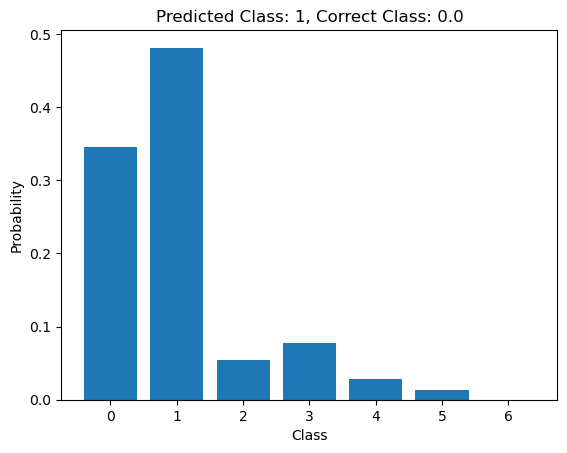

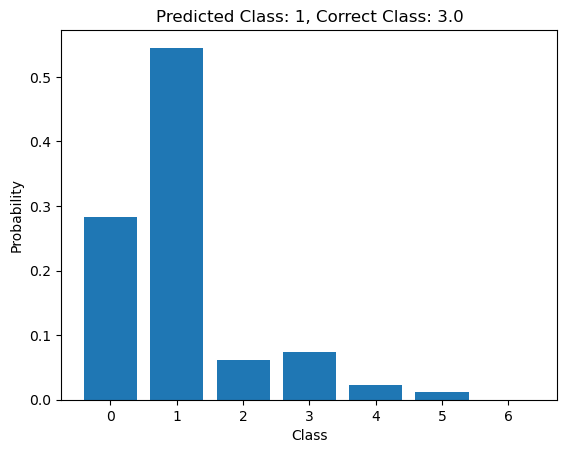

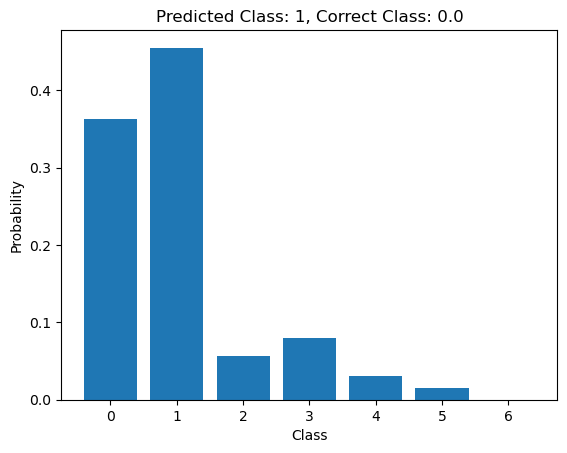

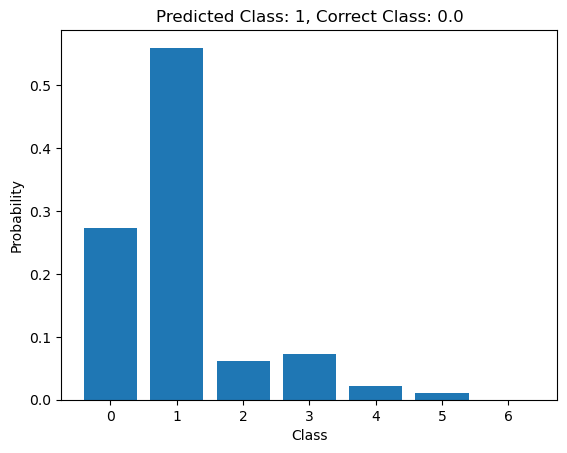

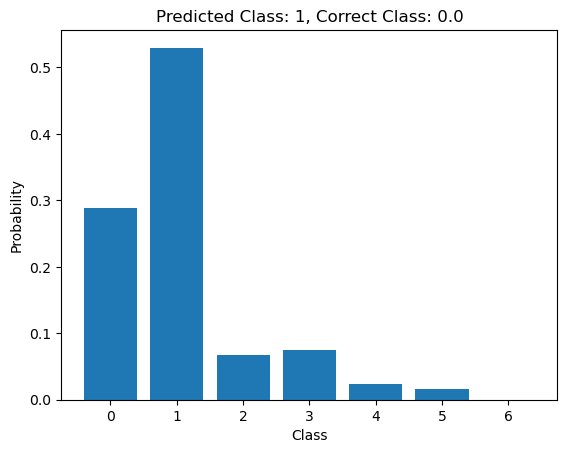

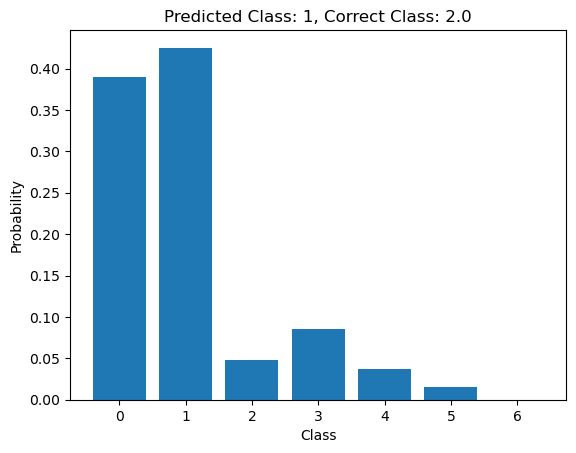

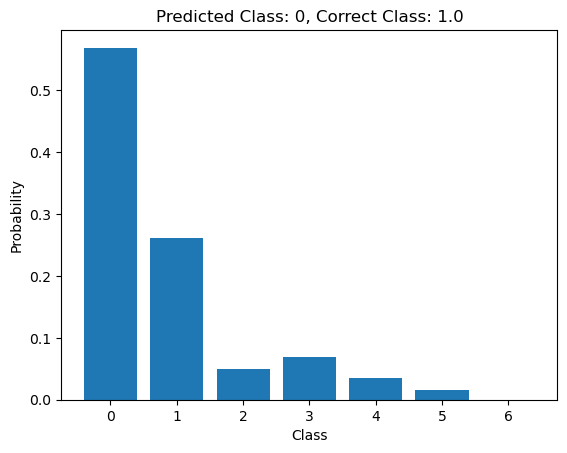

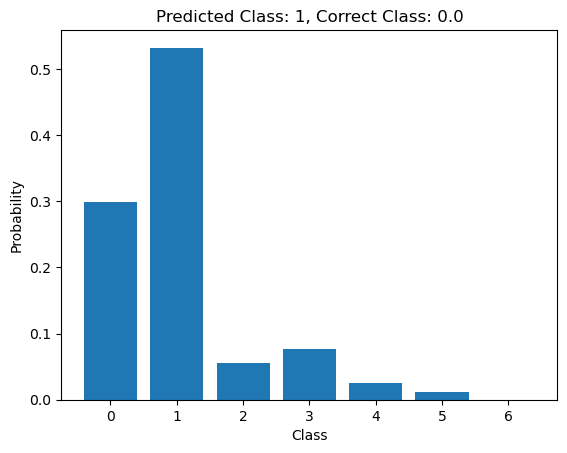

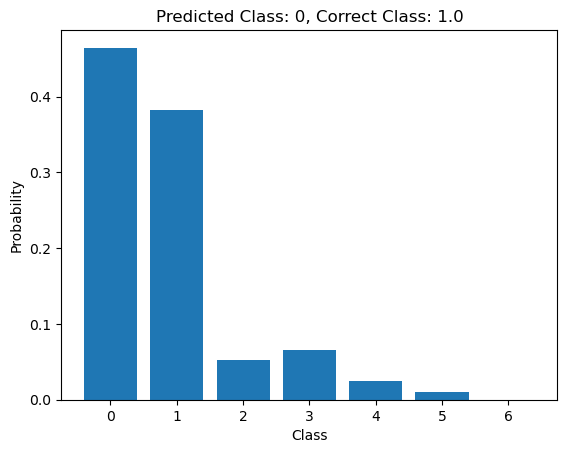

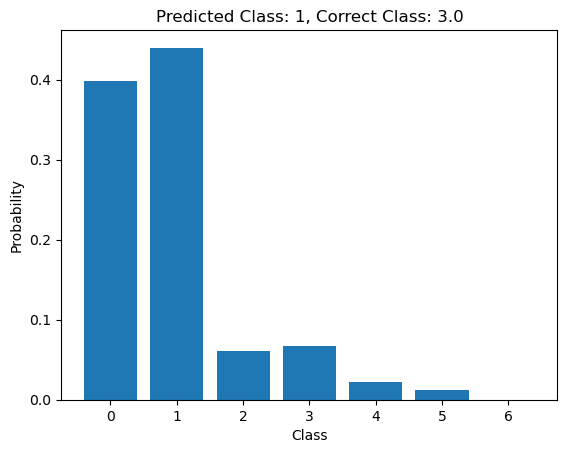

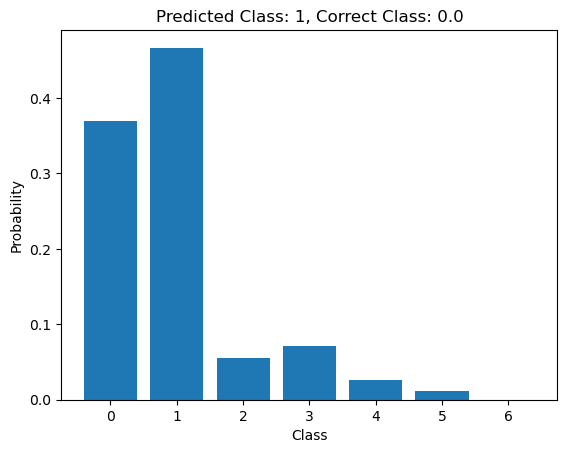

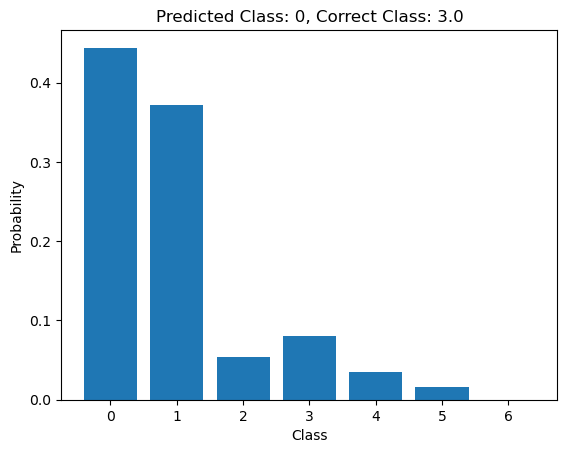

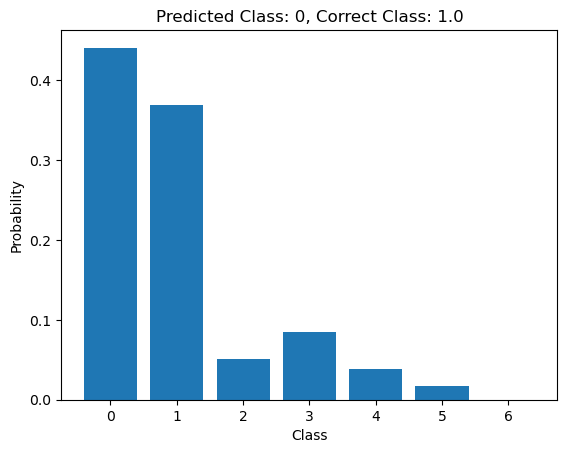

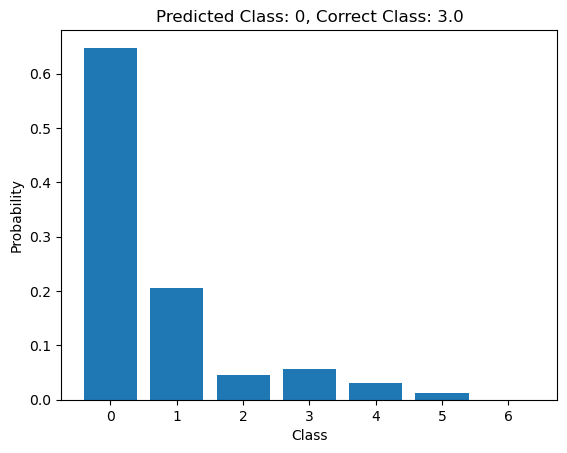

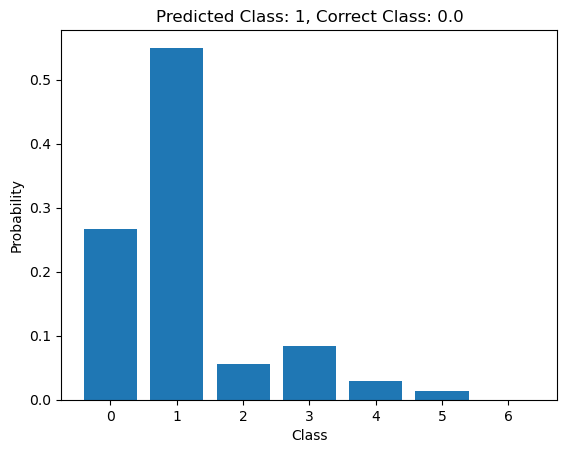

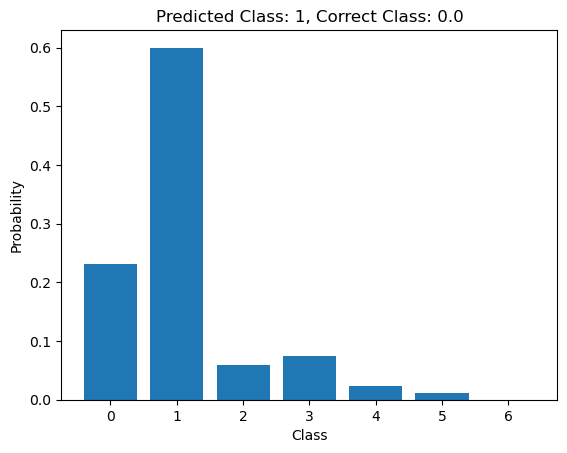

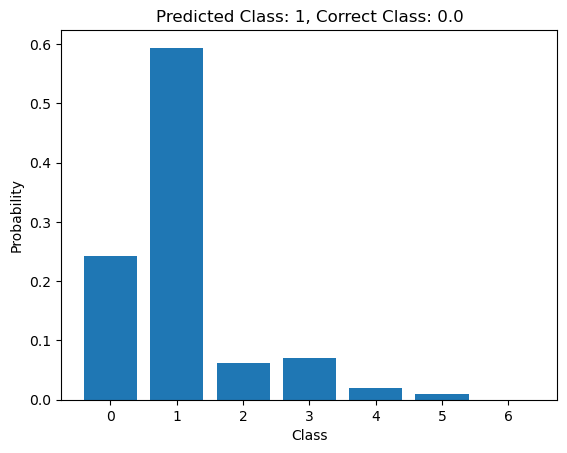

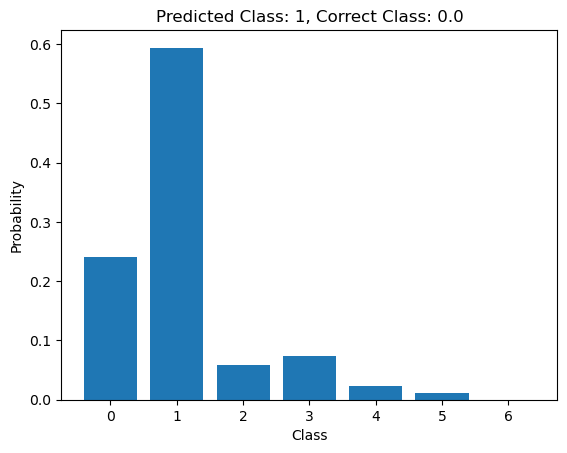

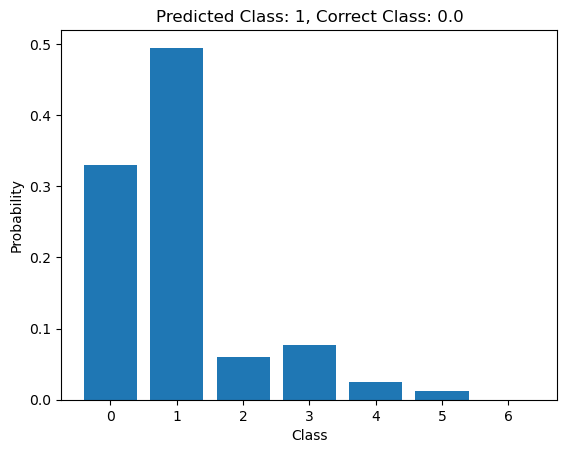

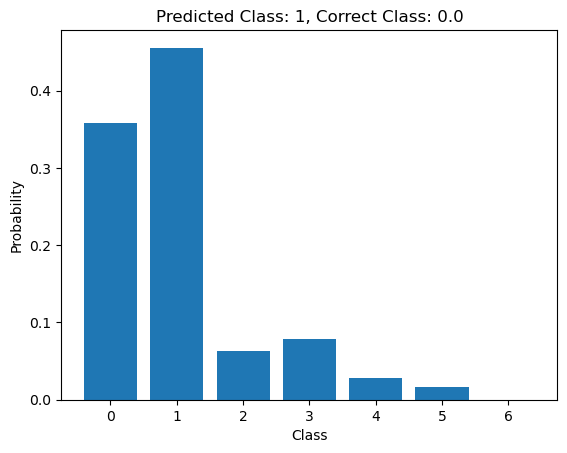

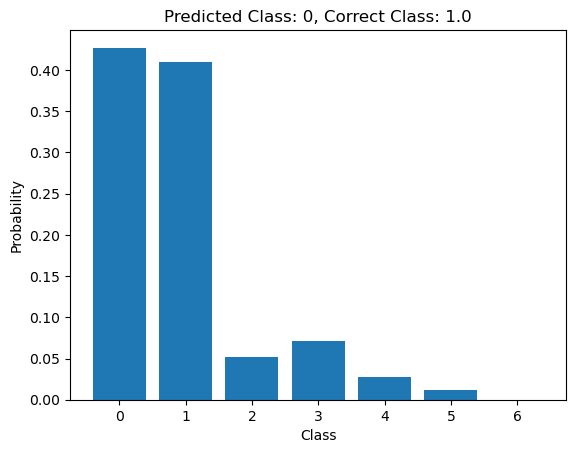

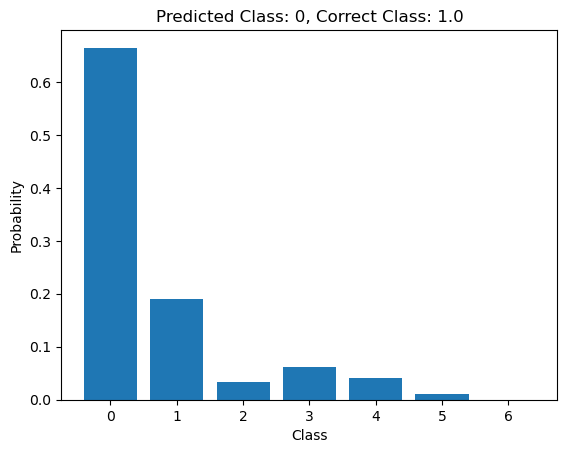

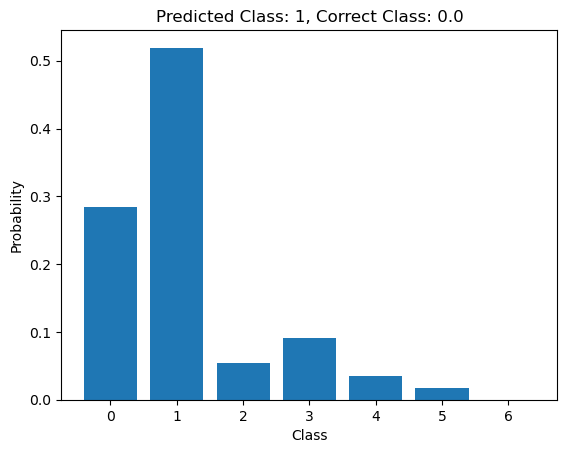

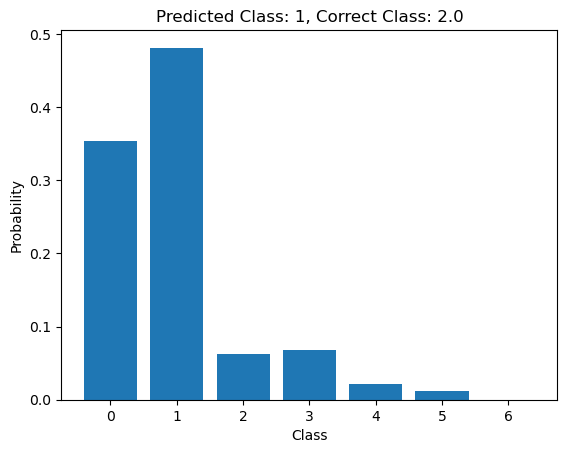

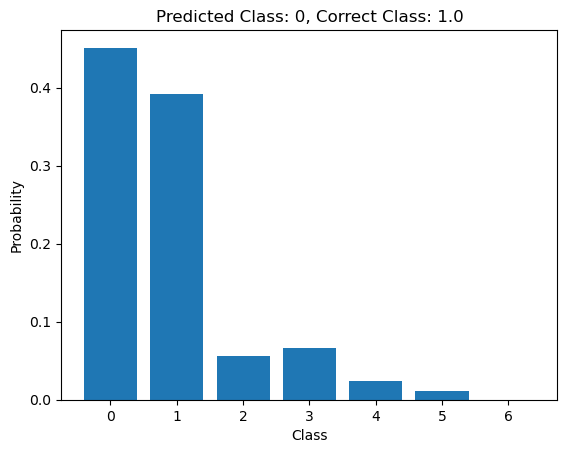

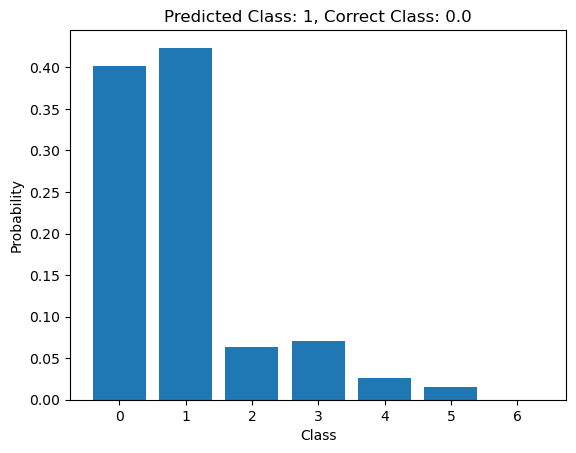

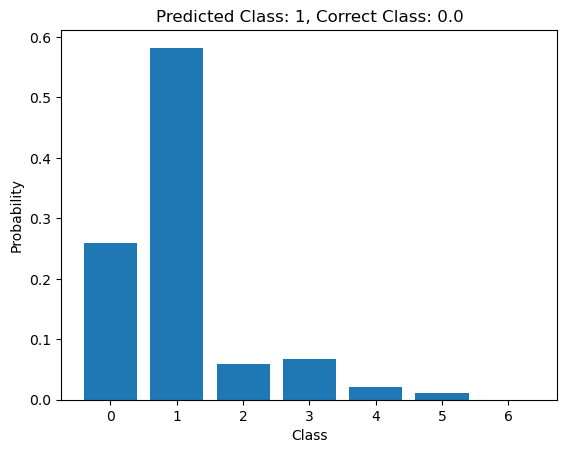

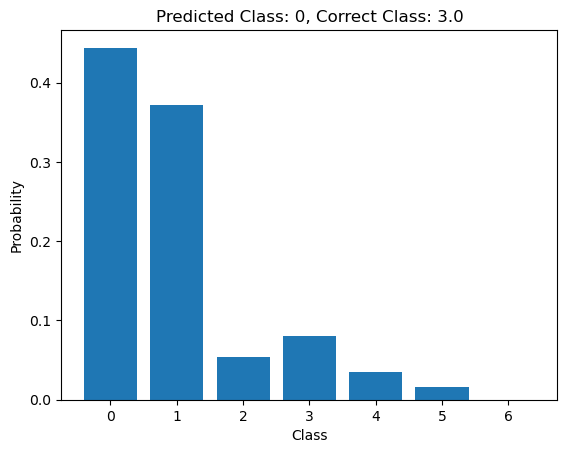

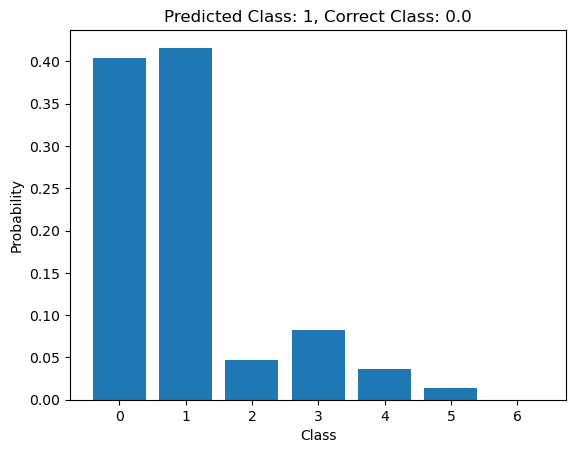

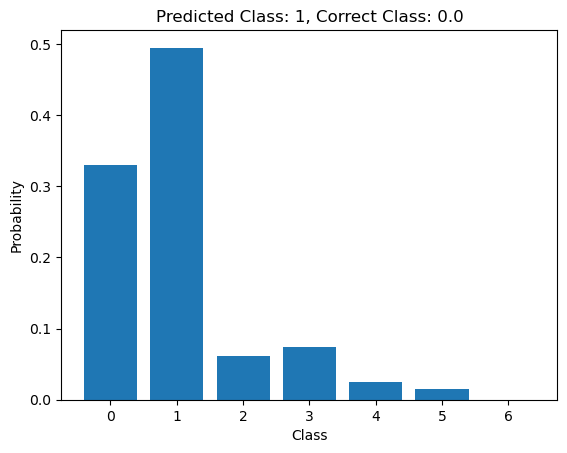

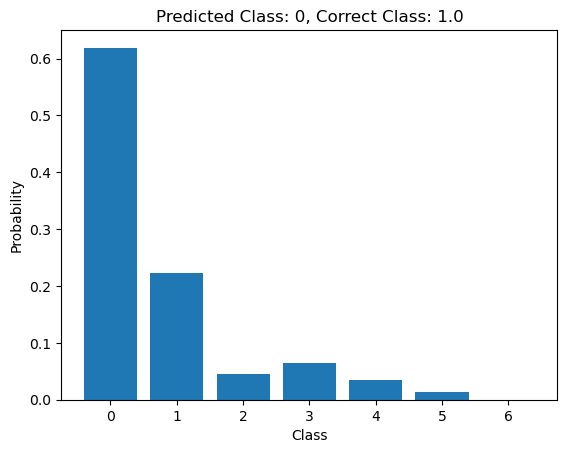

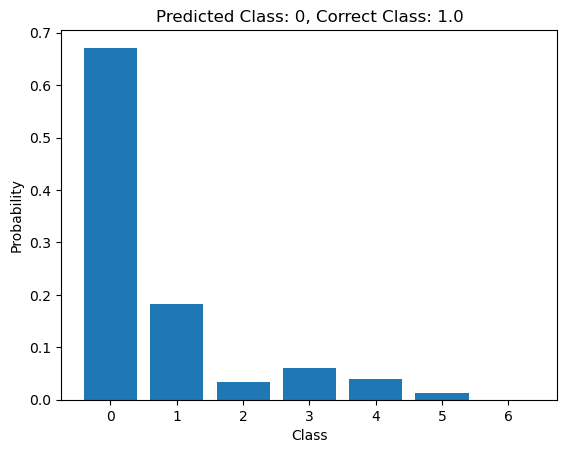

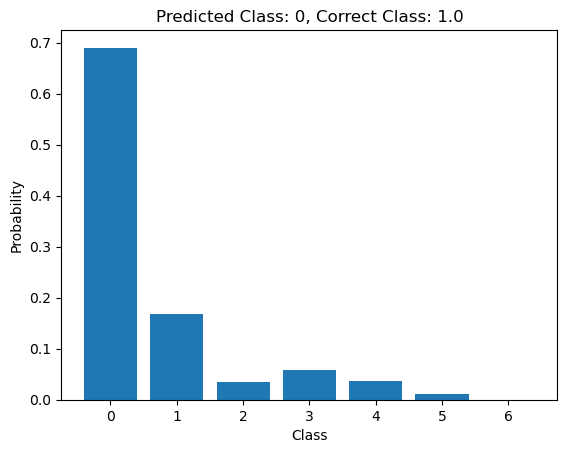

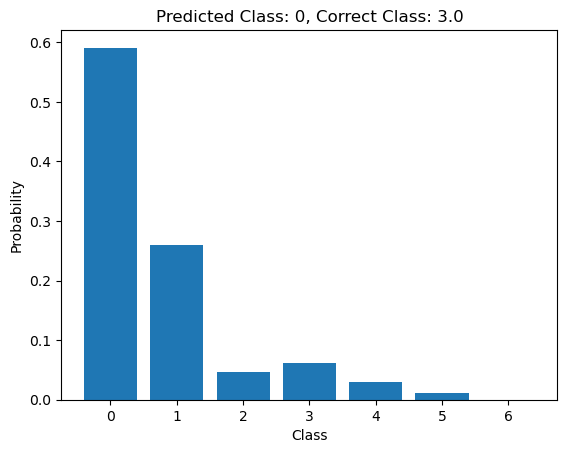

In [97]:
'''In tasks 3 and 4, we tackled two different types of machine learning problems: regression and classification. 
Task 3 focused on regression, where we aimed to predict the number of crime victims as a real number. 
In contrast, Task 4 shifted to a classification problem, predicting the number of crime victims as a class number.
Comparing the results, it's essential to consider the nature of the problem and the specific dataset. 
Task 3, the regression approach, performed well when aiming to predict a continuous value such as the count of 
crime victims. The Mean Squared Error (MSE) loss helped optimize the model to minimize the squared differences
between predicted and actual values. However, Task 4, the classification approach, might yield better results when 
dealing with discrete classes. In this context, using Cross-Entropy Loss and classifying the victim count into 
categories makes more sense. For a real-world scenario, the choice between regression and classification depends on the problem's nature and 
how you want to use the model's output. If you need a precise numerical prediction (as in Task 3), regression is 
suitable. If categorizing victim counts into classes with varying levels of severity or response urgency is more 
practical (as in Task 4), classification is the better choice.'''

import matplotlib.pyplot as plt

# Assuming 'model' is your trained classification model
# 'test_loader' is your data loader for the test data

# Set the model to evaluation mode
model.eval()

correct_classifications = 0
total_samples = 0

misclassified_samples = []

with torch.no_grad():
    for inputs, targets in test_loader:
        test_outputs = model(inputs)
        _, predicted = torch.max(test_outputs, 1)
        total_samples += targets.size(0)
        correct_classifications += (predicted == targets).sum().item()

        # Find and store misclassified samples
        misclassified_mask = predicted != targets
        for i, is_misclassified in enumerate(misclassified_mask):
            if is_misclassified:
                misclassified_samples.append((inputs[i], predicted[i].item(), targets[i].item()))

accuracy = correct_classifications / total_samples
print(f"Accuracy on the test data: {accuracy}")

for sample in misclassified_samples:
    inputs, predicted_class, correct_class = sample
    class_probabilities = torch.softmax(model(inputs), dim=0).detach().numpy()  
    plt.bar(range(len(class_probabilities)), class_probabilities)
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.title(f"Predicted Class: {predicted_class}, Correct Class: {correct_class}")
    plt.show()


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


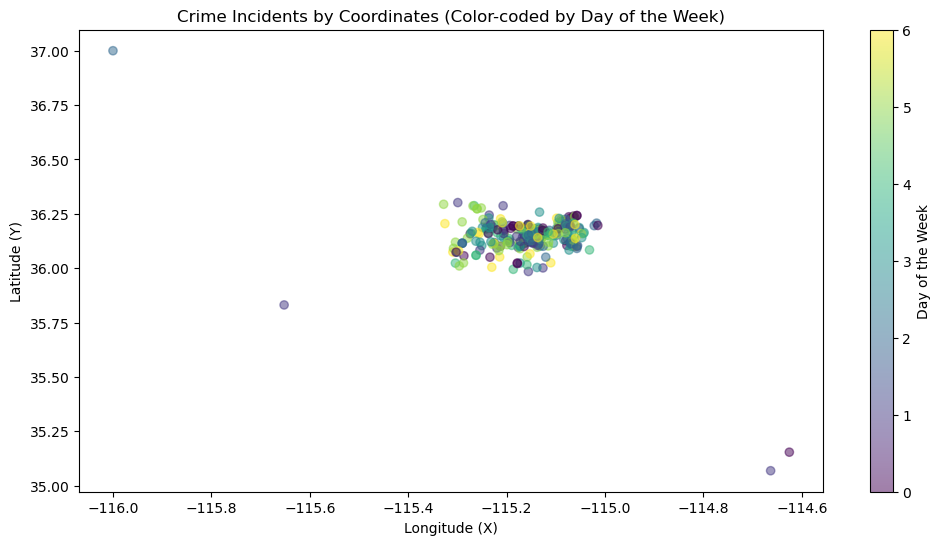

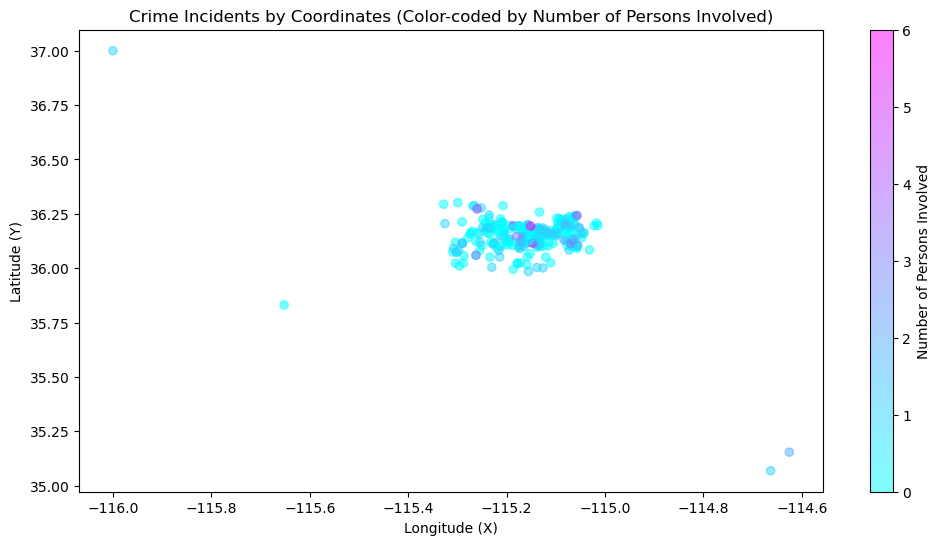

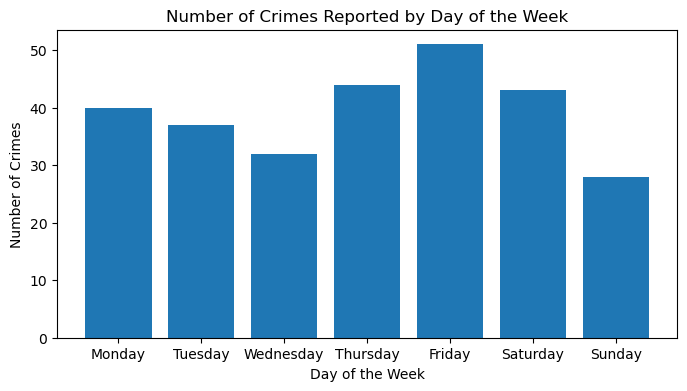

'The first scatter plot shows the crime incidents on a map, with each point color-coded by the day of the week.\nThis plot can help identify any patterns or trends in crimes based on the day.\n\nThe second scatter plot uses the same coordinates but color-codes the points by the number of persons involved in \nthe incident. This can help you identify whether certain incidents with more people involved tend to cluster in \nspecific locations.\n\nThe bar chart displays the frequency of crimes reported by day of the week, providing insights into which days have\nthe highest and lowest crime rates.\n\nBy visualizing the data in this way, you can gain a better understanding of the patterns and trends in the crime \nincident data.\n\n\n\n\n'

In [98]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', alpha=0.5)
plt.title('Crime Incidents by Coordinates (Color-coded by Day of the Week)')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.colorbar(label='Day of the Week')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='cool', alpha=0.5)
plt.title('Crime Incidents by Coordinates (Color-coded by Number of Persons Involved)')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.colorbar(label='Number of Persons Involved')
plt.show()

day_of_week_counts = df['DayOfWeek'].value_counts().sort_index()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(8, 4))
plt.bar(days, day_of_week_counts)
plt.title('Number of Crimes Reported by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.show()

'''The first scatter plot shows the crime incidents on a map, with each point color-coded by the day of the week.
This plot can help identify any patterns or trends in crimes based on the day.

The second scatter plot uses the same coordinates but color-codes the points by the number of persons involved in 
the incident. This can help you identify whether certain incidents with more people involved tend to cluster in 
specific locations.

The bar chart displays the frequency of crimes reported by day of the week, providing insights into which days have
the highest and lowest crime rates.

By visualizing the data in this way, you can gain a better understanding of the patterns and trends in the crime 
incident data.




'''


In [99]:
'''Citations


1. For guidance on data visualization and using Matplotlib in Python, you can refer to the official Matplotlib 
documentation:
   - Matplotlib Documentation: https://matplotlib.org/stable/contents.html

2. To learn more about color mapping and choosing the right color schemes for your visualizations, you might find 
the following resource helpful:
   - Color Brewer 2: https://colorbrewer2.org/
'''

'Citations\n\n\n1. For guidance on data visualization and using Matplotlib in Python, you can refer to the official Matplotlib \ndocumentation:\n   - Matplotlib Documentation: https://matplotlib.org/stable/contents.html\n\n2. To learn more about color mapping and choosing the right color schemes for your visualizations, you might find \nthe following resource helpful:\n   - Color Brewer 2: https://colorbrewer2.org/\n'